In [127]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from math import ceil,sqrt,log2
import matplotlib.pyplot as plt
from typing import Optional

In [128]:
df = pd.read_csv('data.csv')
df

,STUDENT ID,Student Age,Sex,Graduated high-school type,Scholarship type,Additional work,Regular artistic or sports activity,Do you have a partner,Total salary if available,Transportation to the university,...,Preparation to midterm exams 1,Preparation to midterm exams 2,Taking notes in classes,Listening in classes,Discussion improves my interest and success in the course,Flip-classroom,Cumulative grade point average in the last semester (/4.00),Expected Cumulative grade point average in the graduation (/4.00),COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


По условию нужно ввести для данного датасета метрику: студент успешный/неуспешный на основании грейда

In [129]:
# Определение порогового значения для успешности
threshold = 4
# Создание нового столбца 'SUCCESS', в котором студент считается успешным, если его оценка выше порога
df['SUCCESS'] = df['GRADE'].apply(lambda x: 1 if x >= threshold else 0)
df = df.drop('STUDENT ID', axis=1)
X = df.drop('SUCCESS', axis=1)
y=df['SUCCESS']
print(X)
print(y)

     Student Age  Sex  Graduated high-school type  Scholarship type  \
0              2    2                           3                 3   
1              2    2                           3                 3   
2              2    2                           2                 3   
3              1    1                           1                 3   
4              2    2                           1                 3   
..           ...  ...                         ...               ...   
140            2    1                           2                 3   
141            1    1                           2                 4   
142            1    1                           1                 4   
143            2    1                           2                 4   
144            1    1                           1                 5   

     Additional work  Regular artistic or sports activity  \
0                  1                                    2   
1                  1     

In [130]:
#Проверка отсутствующих значений
df.isna().sum()

Student Age                                                          0
Sex                                                                  0
Graduated high-school type                                           0
Scholarship type                                                     0
Additional work                                                      0
Regular artistic or sports activity                                  0
Do you have a partner                                                0
Total salary if available                                            0
Transportation to the university                                     0
Accomodation type in Cyprus                                          0
Mother's education                                                   0
Father's education                                                   0
Number of sisters/brothers                                           0
Parental status                                                      0
Mother

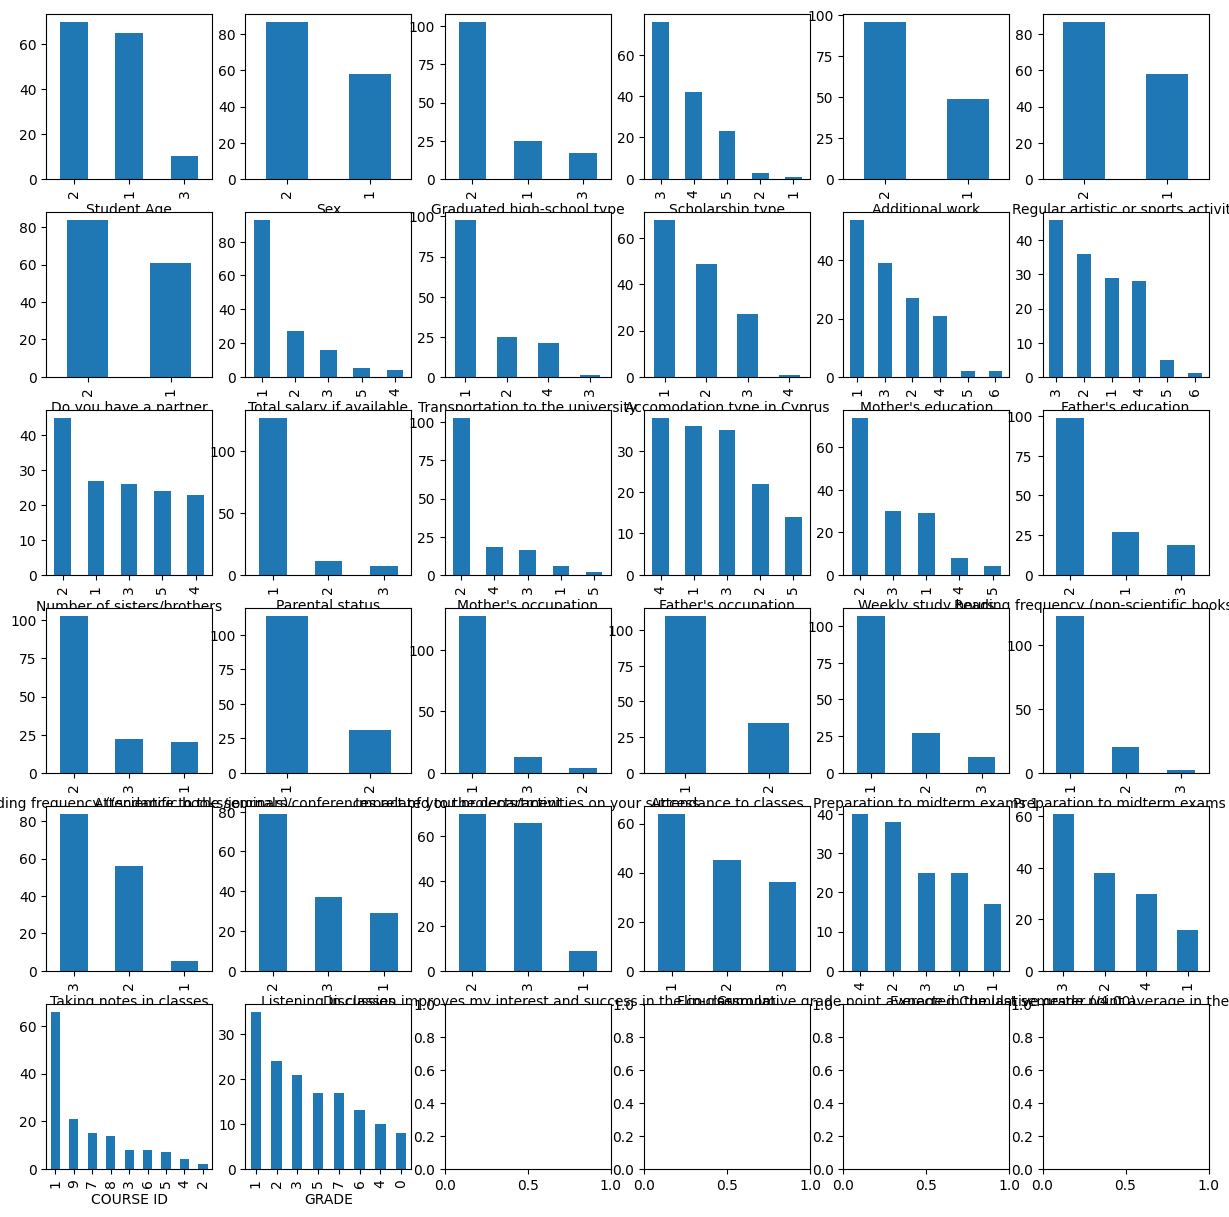

In [131]:
fig, axs = plt.subplots(ceil(sqrt(len(X.columns))), ceil(sqrt(len(X.columns))))
for ax, col in zip(axs.flatten(), X.columns):
    X[col].value_counts().plot(kind="bar", ax=ax)
fig.set_figheight(15)
fig.set_figwidth(15)

<Axes: xlabel='SUCCESS'>

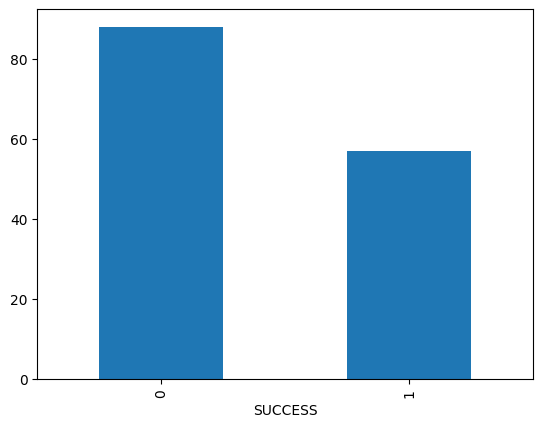

In [132]:
y.value_counts().plot(kind="bar")

**Decision tree**

In [133]:
from math import log2
import pandas as pd

class Node:
    def __init__(self, feature_name: str, value_to_node: dict[str, 'Node']):
        self.feature_name = feature_name
        self.value_to_node = value_to_node

    def pred(self, x):
        feature_value = x[self.feature_name]
        # Если значение признака отсутствует, возвращаем None
        if feature_value not in self.value_to_node:
            return None
        # Рекурсивно вызываем предсказание для следующего узла
        return self.value_to_node[feature_value].pred(x)

    def pred_prob(self, x):
        feature_value = x[self.feature_name]
        # Если значение признака отсутствует, возвращаем 0
        if feature_value not in self.value_to_node:
            return 0
        # Рекурсивно вызываем предсказание с вероятностью для следующего узла
        return self.value_to_node[feature_value].pred_prob(x)

    def print_node(self, indent=0):
        # Выводим информацию о текущем узле и рекурсивно вызываем вывод для дочерних узлов
        for value, node in self.value_to_node.items():
            print(' ' * indent + f'{self.feature_name} == {value}:')
            node.print_node(indent + 2)

class LeafNode(Node):
    def __init__(self, leaf_value: str, prob: float):
        # Листовой узел не имеет feature_name и value_to_node
        super().__init__("", {})
        self.leaf_value = leaf_value
        self.prob = prob

    def pred(self, x):
        # Возвращаем значение листового узла
        return self.leaf_value

    def pred_prob(self, x):
        # Возвращаем значение листового узла и его вероятность
        return self.leaf_value, self.prob

    def print_node(self, indent=0):
        # Выводим информацию о листовом узле
        print(' ' * indent + f'-> {self.leaf_value} ({self.prob})')

class DecisionTree:
    def __init__(self, cols: list[str]):
        self.cols = cols

    def fit(self, x, y):
        # Построение дерева начинается с корня
        self.root = self._build_node(x[self.cols], y, DecisionTree._entropy(y))

    def pred(self, x):
        # Возвращаем предсказания для каждой строки входных данных
        return [self.root.pred(row) for row in x[self.cols].to_records()]

    def pred_prob(self, x):
        # Возвращаем предсказания с вероятностями для каждой строки входных данных
        return [self.root.pred_prob(row) for row in x[self.cols].to_records()]

    def _build_node(self, x, y, parent_info: float) -> Node:
        # Если в узле осталась метка только одного класса, создаем листовой узел
        if len(y.unique()) == 1:
            return LeafNode(y.unique()[0], 1)

        best_gain, best_gain_info, best_gain_col = 0, 0, ''

        # Поиск лучшего разбиения
        for col in self.cols:
            cat_names = pd.unique(x[col])  # Используем pd.unique() вместо x[col].unique()
            info = sum(x[col].value_counts()[cat] / len(x) * DecisionTree._entropy(y[x[col] == cat]) for cat in cat_names)

            # Обновляем параметры лучшего разбиения
            if parent_info - info > best_gain:
                best_gain, best_gain_info, best_gain_col = parent_info - info, info, col

        # Если разделить не удается, возвращаем листовой узел с самым частым классом
        if not best_gain_col:
            mode = y.mode()[0]
            return LeafNode(mode, y.value_counts()[mode] / len(y))

        # Рекурсивный вызов построения следующего узла
        values_to_node = {cat: self._build_node(x[x[best_gain_col] == cat], y[x[best_gain_col] == cat], best_gain_info) for cat in pd.unique(x[best_gain_col])}
        return Node(best_gain_col, values_to_node)

    def print_tree(self):
        # Выводим дерево, начиная с корня
        self.root.print_node()

    @staticmethod
    def _entropy(y) -> float:
        # Вычисляем энтропию для меток классов
        cls_prob = y.value_counts(normalize=True)
        return -sum(p * log2(p) for p in cls_prob if p > 0)

**Train-Test-Split**

In [134]:
samples_amount = 0.3
random_state = 338879

test_x = X.sample(frac=samples_amount, random_state=random_state)
test_y = y[test_x.index]
train_x = X.drop(test_x.index, axis=0)
train_y = y[train_x.index]

**Training**

In [135]:
cols = X.columns
cols = np.random.choice(cols, ceil(sqrt(len(cols))))

print("Используются признаки:", *cols)

tree = DecisionTree(cols)
tree.fit(train_x, train_y)
tree.print_tree()

Используются признаки: Regular artistic or sports activity Preparation to midterm exams 2 Mother's occupation Cumulative grade point average in the last semester (/4.00) Attendance to the seminars/conferences related to the department Impact of your projects/activities on your success
Cumulative grade point average in the last semester (/4.00) == 1:
  Mother's occupation == 2:
    -> 0 (1)
  Mother's occupation == 4:
    -> 0 (1)
  Mother's occupation == 3:
    -> 0 (1)
  Mother's occupation == 1:
    Attendance to the seminars/conferences related to the department == 1:
      -> 1 (1)
    Attendance to the seminars/conferences related to the department == 2:
      -> 0 (1)
Cumulative grade point average in the last semester (/4.00) == 2:
  Mother's occupation == 2:
    Attendance to the seminars/conferences related to the department == 1:
      -> 0 (0.875)
    Attendance to the seminars/conferences related to the department == 2:
      -> 0 (1)
  Mother's occupation == 3:
    -> 0 (1

**Testing**

*Metrics*

Мы будем использовать 1 как положительный признак, 0 - как отрицательный

In [136]:
def confusion_matrix(pred_y, true_y):
    res = np.zeros((2, 2))

    for pred, true in zip(pred_y, true_y):
        pred = 1 if pred == 1 else 0
        true = 1 if true == 1 else 0
        res[pred][true] += 1

    return res

def confusion_matrix_prob(pred_probs, true_y, threshold):
    res = np.zeros((2, 2))

    for pred_prob, true in zip(pred_probs, true_y):
        pred = 1 if pred_prob >= threshold else 0
        true = 1 if true == 1 else 0
        res[pred][true] += 1

    return res

def accuracy(conf):
    return (conf[1][1] + conf[0][0]) / sum(conf.flatten())

def precision(conf):
    return conf[1][1] / (conf[1][1] + conf[1][0])

def recall(conf):
    return conf[1][1] / (conf[1][1] + conf[0][1])

def fallout(conf):
    return conf[1][0] / (conf[1][0] + conf[0][0])
pred_y = tree.pred(test_x)
conf = confusion_matrix(pred_y, test_y)
print(conf)
print('Accuracy:', accuracy(conf))
print('Precision', precision(conf))
print('Recall:', recall(conf))

[[17. 11.]
 [ 8.  8.]]
Accuracy: 0.5681818181818182
Precision 0.5
Recall: 0.42105263157894735


**AUC**

Для ROC и PR



In [137]:
pred_prob = tree.pred_prob(test_x)
probs = []

for i in range(len(pred_prob)):
    # Вместо попытки распаковки проверяем, является ли pred_prob[i] кортежем
    if isinstance(pred_prob[i], tuple):
        pred, prob = pred_prob[i]
        # Если студент успешный
        if pred == 1:
            probs.append(prob)
        else:
            probs.append(1 - prob)
    else:
        # Обрабатываем случай, если pred_prob[i] не является кортежем
        print(f"Warning: Invalid pred_prob format at index {i}")

# Теперь 'probs' содержит корректные значения вероятностей

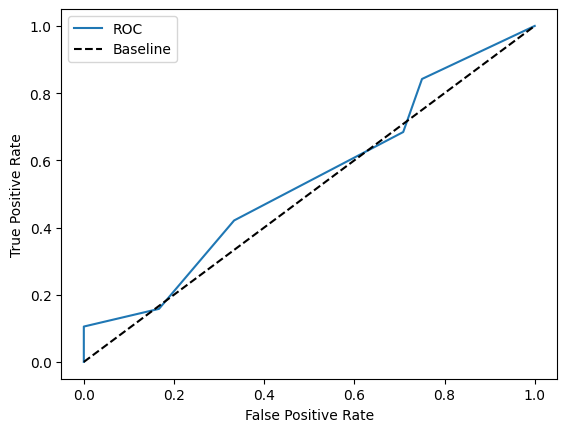

In [138]:
tpr = []
fpr = []

for th in np.arange(1, 0, -0.01):
    conf = confusion_matrix_prob(probs, test_y, th)
    tpr.append(recall(conf))
    fpr.append(fallout(conf))

plt.plot([0] + fpr + [1], [0] + tpr + [1], label='ROC')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

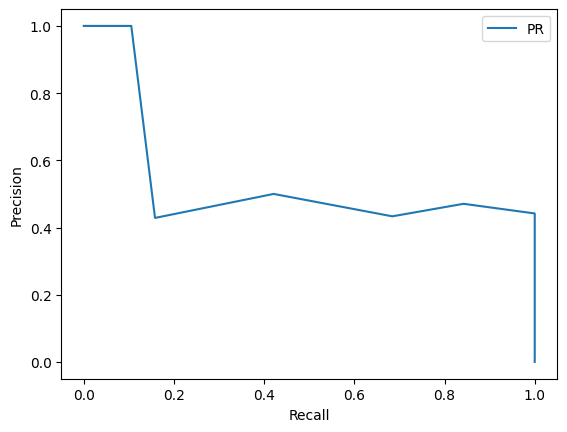

In [139]:
p = []
r = []

for th in np.arange(0, 1, 0.01):
    conf = confusion_matrix_prob(probs, test_y, th)
    p.append(precision(conf))
    r.append(recall(conf))

plt.plot([1] + r + [0], [0] + p + [1], label='PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()